# Implementation du modèle PainAttnNet pour une Classification Supervisée de signaux EEG

### Importation des bibliothèques utilisées

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split  
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch.nn.functional as F
import copy
from copy import deepcopy

# Paramétrage de la seed pour la reproductibilité
torch.manual_seed(0)
np.random.seed(0)

#Version des librairies utilisées
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.5.1
Torchvision version: 0.20.1
Numpy version: 1.26.4


---
---
# Importation et formatage des données pour l'entraînement

### Importation, filtrage et création du Dataset

Les données ont été extraites de la base de données et rangées dans l'ordre en fonction du set dont elles proviennent dans le fichier "data.pkl" (les 100 signaux du set A, puis les 100 du set B, etc. jusqu'à E). À chaque signal, on a ajouté au début son label correspondant (A => 1, B => 2, etc.).

Après avoir importé les données, et selon les spécifications de la base de données, il est conseillé de filtrer les signaux avec un filtre passe-bande de f1 = 0.53 Hz et f2 = 40 Hz.

Une fois les signaux filtrés, ils sont ajoutés à un Dataset personnalisé qui attribue les bons labels en fonction du set d'où ils proviennent et de la classification souhaitée.

In [5]:
# Charger les données depuis le fichier data.pkl dans un tensor
with open('data.pkl', 'rb') as file:
    data = pickle.load(file)

# Séparer les labels des données
labels = data[:, 0]  # La première colonne correspond aux labels
signals = data[:, 1:]  # Les colonnes restantes sont les données à filtrer

# Définir les fréquences de coupure et la fréquence d'échantillonnage du signal
low_cutoff = 0.53
high_cutoff = 40
sample_rate = 173.61

# Conception du filtre passe-bande
nyquist = 0.5 * sample_rate
low = low_cutoff / nyquist
high = high_cutoff / nyquist
b, a = butter(4, [low, high], btype='band')

# Appliquer le filtre passe-bande aux données
filtered_signals = filtfilt(b, a, signals, axis=1)

# Faire une copie des signaux filtrés pour éviter les strides négatifs
filtered_signals = filtered_signals.copy()

# Définir un Dataset personnalisé pour les signaux EEG
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, signals, labels):
        # Convertir les signaux et les labels en tensors
        self.signals = torch.tensor(signals, dtype=torch.float32).unsqueeze(1)  # Ajouter une dimension pour le canal
        self.labels = torch.tensor(labels, dtype=torch.long)
        
        # Modifier les labels pour les classes sain et malade
        for idx in range(len(self.labels)):
            if labels[idx] in [1, 2]:  # Classes A et B
                self.labels[idx] = 0
            elif labels[idx] in [3, 4]:  # Classes C et D
                self.labels[idx] = 1
            elif labels[idx] == 5:  # Classe E
                self.labels[idx] = 2

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]
    
    def __getlabel__(self, idx):
        return self.labels[idx]

# Créer le dataset personnalisé
dataset = EEGDataset(filtered_signals, labels)


### Comparaison visuelle du signal filtré et original

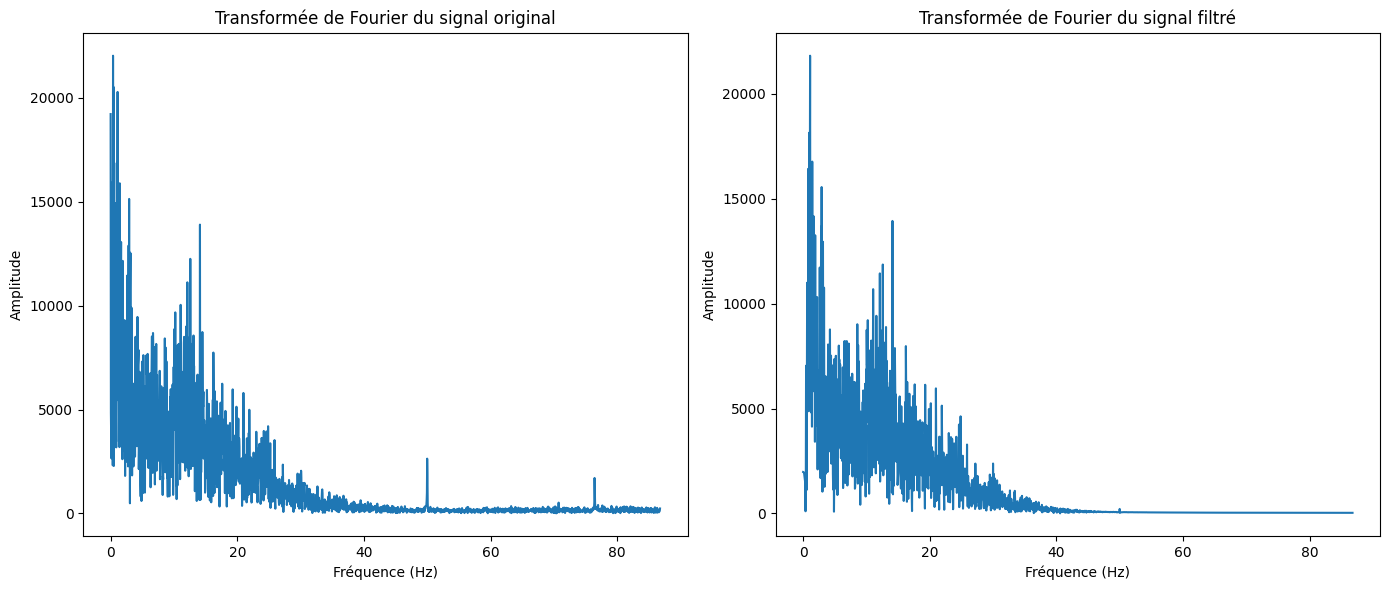

In [6]:
# Transformée de Fourier d'un des signaux filtrés et de sa version originale

# Sélectionner un signal aléatoire
random_index = np.random.randint(0, data.shape[0])
original_signal = data[random_index]
filtered_signal = filtered_signals[random_index]

# Calculer la transformée de Fourier pour le signal original et le signal filtré
original_fft = np.fft.fft(original_signal)
filtered_fft = np.fft.fft(filtered_signal)

# Calculer les fréquences correspondantes
freqs = np.fft.fftfreq(len(original_signal), d=1/sample_rate)

# Ajuster les longueurs pour correspondre à la moitié du spectre (symétrie)
half_n = len(original_signal) // 2
freqs = freqs[:half_n]
original_fft = original_fft[:half_n]
filtered_fft = filtered_fft[:half_n]

# Afficher les résultats
plt.figure(figsize=(14, 6))

# Transformée de Fourier du signal original
plt.subplot(1, 2, 1)
plt.plot(freqs, np.abs(original_fft))
plt.title('Transformée de Fourier du signal original')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

# Transformée de Fourier du signal filtré
plt.subplot(1, 2, 2)
plt.plot(freqs, np.abs(filtered_fft))
plt.title('Transformée de Fourier du signal filtré')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

### Division des données en ensembles d'entraînement, de validation et de test

In [7]:
# Définir les tailles pour chaque ensemble (entraînement, validation, test)
train_size = int(0.6 * 100)  # 60% des échantillons, soit 60 échantillons par classe
val_size = int(0.2 * 100)    # 20% des échantillons, soit 20 échantillons par classe
test_size = 100 - train_size - val_size  # Les 20% restants, soit 20 échantillons par classe

# Initialiser des listes vides pour chaque ensemble
train_data_list = []
val_data_list = []
test_data_list = []

# Diviser chaque classe séparément et combiner les ensembles pour garder les mêmes proportions de chaque classe dans les ensembles
for set_start in range(0, len(dataset), 100):  # Chaque set contient 100 échantillons
    set_data = torch.utils.data.Subset(dataset, range(set_start, set_start + 100))
    class_splits = random_split(set_data, [train_size, val_size, test_size])
    train_data_list.append(class_splits[0])
    val_data_list.append(class_splits[1])
    test_data_list.append(class_splits[2])

# Combiner les ensembles divisés en utilisant ConcatDataset
train_data = torch.utils.data.ConcatDataset(train_data_list)
val_data = torch.utils.data.ConcatDataset(val_data_list)
test_data = torch.utils.data.ConcatDataset(test_data_list)

# Créer des DataLoaders pour chaque ensemble
batch_size = 128  # Taille du batch
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Afficher la taille de chaque ensemble
print("Ensemble d'entraînement :", len(train_data))  
print("Ensemble de validation :", len(val_data))  
print("Ensemble de test :", len(test_data))

Ensemble d'entraînement : 300
Ensemble de validation : 100
Ensemble de test : 100


### Visulation d'un extrait de batch d'entrainement

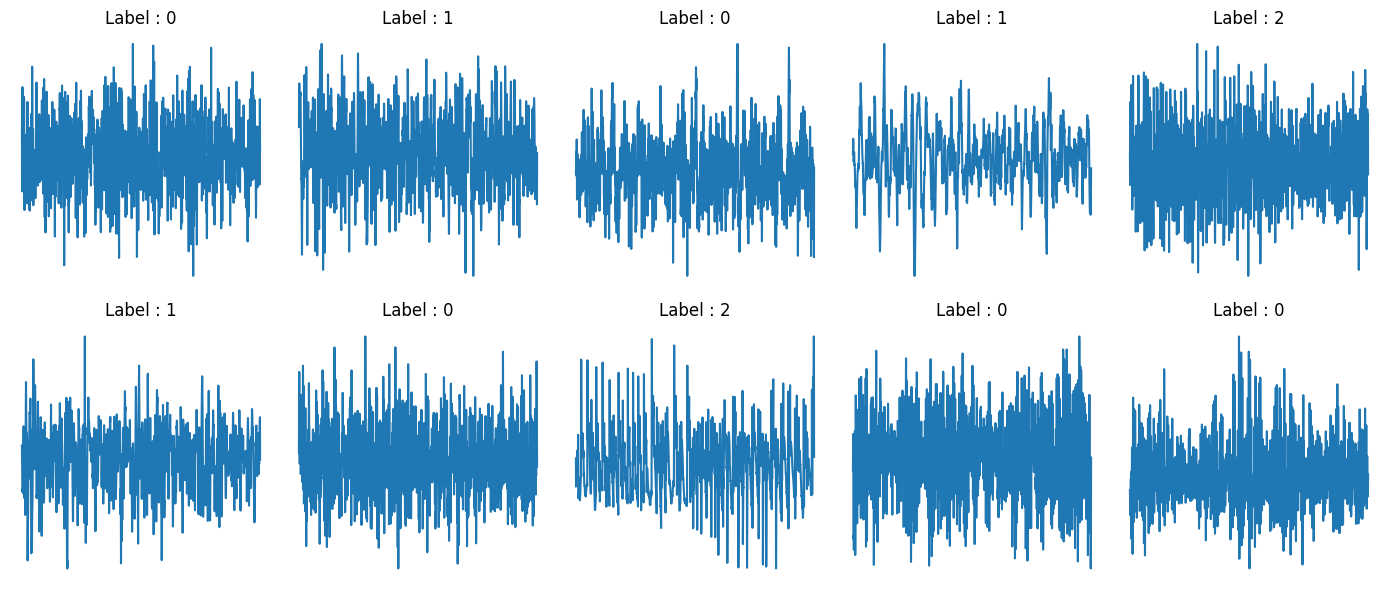

In [13]:
# Sélectionner un batch aléatoire de signaux d'entraînement
dataiter = iter(train_loader)
signals, labels = next(dataiter)
signals = signals.numpy()

# Afficher les signaux dans le batch, avec les labels correspondants
plt.figure(figsize=(14, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.plot(signals[i].T)
    plt.title(f"Label : {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


---
---
# Définition de l'architecture du réseau

In [14]:
# Définir les paramètres de l'architecture du réseau

# Taux d'apprentissage
learning_rate = 0.0003

# Nombre d'époques pour entraîner le modèle
n_epochs = 20

# Taille des signaux d'entrée
# On récupère la taille des signaux d'entrée à partir du premier batch du DataLoader d'entraînement
input_size = next(iter(train_loader))[0].shape

# Afficher les paramètres pour vérification
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {n_epochs}")
print(f"Input Size: {input_size}")

Learning Rate: 0.0003
Number of Epochs: 20
Input Size: torch.Size([128, 1, 4097])


### Définition du modèle PainAttnNet

Le code ci-dessous a été récupéré sur Github et adapté à notre problème. 

Voici le lien du Github : https://github.com/zhenyuanlu/PainAttnNet 

In [15]:
# Définition du modèle MSCN (Multi-Scale Convolutional Network)
class MSCN(nn.Module):
    def __init__(self, mscn_output_channels, model_dim, kernel_size_short, kernel_size_medium, kernel_size_long, stride_short, stride_medium, stride_long):
        super().__init__()
        dropout = 0.5

        # Convolutions à courte échelle
        self.short_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_short, stride_short, dilation=1, bias=False, padding=9),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=8, stride=2, padding=4),
            nn.Dropout(dropout),
            nn.Conv1d(mscn_output_channels, 128, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Conv1d(128, mscn_output_channels, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=4, stride=4, padding=2)
        )

        # Convolutions à moyenne échelle
        self.medium_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_medium, stride_medium, dilation=1, bias=False, padding=38),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(dropout),
            nn.Conv1d(mscn_output_channels, 128, kernel_size=4, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Conv1d(128, mscn_output_channels, kernel_size=4, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        # Convolutions à longue échelle
        self.long_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_long, stride_long, dilation=1, bias=False, padding=67),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=8, stride=8, padding=0),
            nn.Dropout(dropout),
            nn.Conv1d(mscn_output_channels, 128, kernel_size=8, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Conv1d(128, mscn_output_channels, kernel_size=8, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        # Test de passage avant pour déterminer la taille de sortie de chaque échelle
        x_short_test = self.short_scale(torch.randn(1, 1, 4097))
        x_medium_test = self.medium_scale(torch.randn(1, 1, 4097))
        x_long_test = self.long_scale(torch.randn(1, 1, 4097))

        # Couches entièrement connectées pour chaque échelle
        self.fc_short = nn.Linear(x_short_test.shape[2], model_dim)
        self.fc_medium = nn.Linear(x_medium_test.shape[2], model_dim)
        self.fc_long = nn.Linear(x_long_test.shape[2], model_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Passage avant à travers chaque échelle
        x_short1 = self.short_scale(x)
        x_medium1 = self.medium_scale(x)
        x_long1 = self.long_scale(x)

        # Couches entièrement connectées
        x_short2 = self.fc_short(x_short1)
        x_medium2 = self.fc_medium(x_medium1)
        x_long2 = self.fc_long(x_long1)

        # Concatenation des sorties de chaque échelle
        x_concat = torch.cat((x_short2, x_medium2, x_long2), dim=1)

        # Application du dropout
        x_concat = self.dropout(x_concat)

        return x_concat, x_short1, x_medium1, x_long1


In [16]:
# Modèle SEResNet (Réseau résiduel avec blocs squeeze-and-excitation)

"""
Ce module contient l'implémentation de l'architecture SEResNet.
"""

# Définition du bloc Squeeze-and-Excitation.
class SENet(nn.Module):
    """
    Bloc Squeeze-and-Excitation pour l'attention par canal.
    """

    def __init__(self, channel, reduction=16): 
        super(SENet, self).__init__()
        # Moyenne adaptative pour chaque canal
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Couches entièrement connectées pour créer les poids d'attention
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        # Multiplication de l'entrée par les poids d'attention
        return x * y.expand_as(x)


# Définition du bloc de base qui prépare l'entrée avant de l'envoyer au bloc SE et ajoute l'entrée globale à la sortie du bloc SE.
class SEBasicBlock(nn.Module):
    """
    Bloc de base pour les réseaux squeeze-and-excitation avec d'autres couches.
    """
    expansion = 1

    def __init__(self, input_channels, output_channels, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, reduction=16):
        super(SEBasicBlock, self).__init__()
        # Première couche de convolution avec normalisation par lots et activation ReLU
        self.conv1 = nn.Conv1d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        # Deuxième couche de convolution avec normalisation par lots
        self.conv2 = nn.Conv1d(output_channels, output_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(output_channels)
        # Bloc SE
        self.se = SENet(output_channels, reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        # Première couche de convolution
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Deuxième couche de convolution
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        # Downsample si nécessaire
        if self.downsample is not None:
            residual = self.downsample(x)

        # Ajout de la connexion résiduelle et application de ReLU
        out += residual
        out = self.relu(out)

        return out


# Création de l'architecture ResNet avec un nombre donné de blocs SEBasicBlock mis bout à bout.
class SEResNet(nn.Module):
    """
    Réseau résiduel avec blocs squeeze-and-excitation.

    Le downsampling est effectué par conv1 lorsque stride != 1 ou
    lorsque la taille des input_channels n'est pas égale à la taille de sortie.
    """
    def __init__(self, output_channels, block_size, mscn_output_channels_times3):
        super(SEResNet, self).__init__()
        self.input_channels = mscn_output_channels_times3  # Nombre de cartes de caractéristiques en entrée
        self.block = SEBasicBlock
        self.layer = self._make_layer(self.block, output_channels, block_size)

    # Création d'une couche avec un nombre donné de blocs SEBasicBlock.
    def _make_layer(self, block, output_channels, blocks, stride=1):
        downsample = self._downsample_layer(self.input_channels, output_channels * block.expansion, stride)

        layers = [block(self.input_channels, output_channels, stride, downsample)]
        self.input_channels = output_channels * block.expansion
        layers.extend(block(self.input_channels, output_channels) for _ in range(1, blocks))

        return nn.Sequential(*layers)

    @staticmethod
    def _downsample_layer(input_channels, output_channels, stride):
        if stride != 1 or input_channels != output_channels:
            return nn.Sequential(
                nn.Conv1d(input_channels, output_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(output_channels)
            )
        return None

    def forward(self, x):
        return self.layer(x)

In [17]:
# Modèle TransformerEncoder (Encodeur Transformer)

# Fonction utilitaire pour cloner des modules
def clones(module, N): 
    """
    Génère N couches identiques

    Args:
        module (nn.Module): Module PyTorch à cloner
        N (int): Nombre de clones à créer

    Returns:
        nn.ModuleList: Liste de N modules PyTorch clonés
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class TCN(nn.Module):
    """
    Réseau de Convolution Temporelle avec padding causal, connexions résiduelles et normalisation par lot

    Lorsque kernel_size est égal à zéro, le padding n'est pas causal
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, causal=True):
        super(TCN, self).__init__()
        padding = (kernel_size - 1) * dilation if causal else 0
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.causal = causal
        self.tcn_padding = padding
        self.downsample = None

        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))

        if self.causal:
            out = out[:, :, :-self.tcn_padding]

        out = self.bn2(self.conv2(out))

        if self.causal:
            out = out[:, :, :-self.tcn_padding]

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class MultiHeadAttention(nn.Module):
    """
    Attention Multi-Têtes
    """
    def __init__(self, num_heads, model_dim, se_reduced_size, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.tcn = clones(TCN(se_reduced_size, se_reduced_size, kernel_size=7), 2)
        # Si batch_first=True est défini pour nn.MultiheadAttention(),
        # alors les tenseurs d'entrée et de sortie sont fournis sous la forme (batch, seq, feature(channels))
        self.multihead_attention = nn.MultiheadAttention(se_reduced_size, num_heads, batch_first=True, dropout=dropout)

    def forward(self, query, key, value):
        """
        Nous échangeons les dimensions seq et channel pour les tenseurs d'entrée
        afin de répondre aux exigences de nn.MultiheadAttention()
        e.g. BioVid, (batch_size=128, seq_len=75, out_channels=30)
        :return: dimension (batch_size, out_channels, seq_len)
        """
        query = query.transpose(1, 2)
        key = self.tcn[0](key).transpose(1, 2)
        value = self.tcn[1](value).transpose(1, 2)
        attn_output, attn_output_weights = self.multihead_attention(query, key, value)
        # Revenir aux dimensions d'origine
        attn_output = attn_output.transpose(1, 2)
        return attn_output


class MLP(nn.Module):
    """
    Perceptron Multi-Couches
    """
    def __init__(self, model_dim, d_mlp, dropout=0.1):
        super(MLP, self).__init__()
        self.w_1 = nn.Linear(model_dim, d_mlp)
        self.w_2 = nn.Linear(d_mlp, model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Passage avant du MLP
        """
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class LayerNorm(nn.Module):
    """
    Normalisation de Couche
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerOutput(nn.Module):
    """
    Connexion résiduelle suivie d'une normalisation de couche.
    """
    def __init__(self, se_reduced_size, dropout):
        super(SublayerOutput, self).__init__()
        self.norm = nn.LayerNorm(se_reduced_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Appliquer une connexion résiduelle à n'importe quelle sous-couche de même taille.
        """
        normalized_x = self.norm(x.transpose(1, 2)).transpose(1, 2)
        return x + self.dropout(sublayer(normalized_x)) 


class TransformerEncoder(nn.Module):
    """
    Encodeur Transformer

    Intégration de MHA et MLP.
    Chacune de ces sous-couches a une connexion résiduelle et une normalisation de couche, implémentées par SublayerOutput.
    """
    def __init__(self, model_dim, self_attn, feed_forward, se_reduced_size, dropout):
        super(TransformerEncoder, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer_output = clones(SublayerOutput(se_reduced_size, dropout), 2)
        self.size = model_dim
        self.conv = TCN(se_reduced_size, se_reduced_size, kernel_size=7)

    def forward(self, x_in):
        query = self.conv(x_in)
        # Auto-attention de l'encodeur
        x = self.sublayer_output[0](query, lambda x: self.self_attn(query, x_in, x_in))
        return self.sublayer_output[1](x, self.feed_forward)


class EncoderWrapper(nn.Module):
    """
    Wrapper de l'Encodeur Transformer

    C'est une pile de N couches d'encodeur transformer, par défaut N=2.
    """
    def __init__(self, num_heads, model_dim, se_reduced_size, d_mlp, dropout, N):
        super(EncoderWrapper, self).__init__()
        attn = MultiHeadAttention(num_heads, model_dim, se_reduced_size)
        mlp = MLP(model_dim, d_mlp, dropout)
        layer = TransformerEncoder(model_dim, deepcopy(attn), deepcopy(mlp), se_reduced_size, dropout)
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)


### Instanciation du modèle complet

In [19]:
# PainAttnNet model
"""
main_painAttnNet.py

Modèle PainAttnNet : Le modèle principal de l'article
Modules : MSCN, SEResNet et Encodeur Transformer
"""

class PainAttnNet(nn.Module):
    """
    Modèle PainAttnNet
    """
    def __init__(self):
        super(PainAttnNet, self).__init__()

        # Nombre de piles d'encodeurs Transformer
        N = 1
        # Dimension du modèle à partir de MSCN
        model_dim = 25  # Anciennement 75
        # Dimension du MLP
        d_mlp = 30
        # Nombre de têtes d'attention
        num_heads = 5
        # Taux de dropout
        dropout = 0.1
        # Taille de sortie de SEResNet
        senet_reduced_size = 10  # Anciennement 30
        # Nombre de classes
        num_classes = 3
        # Canaux de sortie de MSCN
        mscn_output_channels = 20  # Anciennement 64

        # Paramètres de MSCN
        kernel_size_short = 9  # Anciennement 18
        kernel_size_medium = 38  # Anciennement 76
        kernel_size_long = 67  # Anciennement 134
        stride_short = 1  # Anciennement 2
        stride_medium = 5  # Anciennement 10
        stride_long = 9  # Anciennement 17

        # Réseau de Convolution Multi-Échelle (MSCN)
        self.mscn = MSCN(mscn_output_channels, model_dim, kernel_size_short, kernel_size_medium, kernel_size_long, stride_short, stride_medium, stride_long)
        
        # Réseau SEResNet
        self.seresnet = SEResNet(senet_reduced_size, 1, mscn_output_channels * 3)
        
        # Encodeur Transformer
        self.encoderWrapper = EncoderWrapper(num_heads, model_dim, senet_reduced_size, d_mlp, dropout, N)
        
        # Couche entièrement connectée pour produire la prédiction finale
        self.fc = nn.Linear(model_dim * senet_reduced_size, num_classes)

    def forward(self, x):
        # Passage avant à travers MSCN
        mscn_feat, _, _, _ = self.mscn(x)
        
        # Passage avant à travers SEResNet
        se_feat = self.seresnet(mscn_feat)
        
        # Passage avant à travers l'encodeur Transformer
        transformer_feat = self.encoderWrapper(se_feat)
        
        # Aplatir la sortie de l'encodeur Transformer pour l'entrée dans la couche entièrement connectée
        transformer_feat = transformer_feat.contiguous().view(transformer_feat.shape[0], -1)
        
        # Prédiction finale
        final_output = self.fc(transformer_feat)
        
        return final_output, transformer_feat

# Créer le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PainAttnNet().to(device)
print(model)
print(f"Nombre total de paramètres : {sum(p.numel() for p in model.parameters())}")

PainAttnNet(
  (mscn): MSCN(
    (short_scale): Sequential(
      (0): Conv1d(1, 20, kernel_size=(9,), stride=(1,), padding=(9,), bias=False)
      (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): MaxPool1d(kernel_size=8, stride=2, padding=4, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.5, inplace=False)
      (5): Conv1d(20, 128, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
      (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): GELU(approximate='none')
      (8): Conv1d(128, 20, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
      (9): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): GELU(approximate='none')
      (11): MaxPool1d(kernel_size=4, stride=4, padding=2, dilation=1, ceil_mode=False)
    )
    (medium_scale): Sequential(
      (0): Conv1d(1, 20, kernel_size=(38,), stride=(5,)

---
---

### Entrainement du modèle

In [11]:
learning_rate = 0.001
n_epochs = 30

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss and accuracy for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

best_valid_loss = float('inf')  # to track the best validation loss
best_model = None  # to store the best model
best_epoch = 0  # to track the epoch number of the best model

model.train()  # prepare model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    correct_train = 0
    total_train = 0    
    model.train()  # ensure the model is in training mode

    ###################
    # train the model #
    ###################
    for iteration, batch_data in enumerate(train_loader, start=0):
        # Load data and target samples stored the current batch_data
        data, target = batch_data[0].to(device), batch_data[1].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output,_ = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
        # Calculate accuracy for training set
        _, predicted_train = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted_train == target).sum().item()        
        
    # Calculate average training loss and accuracy over the epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    ###################
    # Validation step #
    ###################    
    model.eval()  # set model to evaluation mode
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():  # disable gradient calculation during validation
        for batch_data in valid_loader:
            # Load data and target samples stored the current batch_data
            data, target = batch_data[0].to(device), batch_data[1].to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output,_ = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update running validation loss
            valid_loss += loss.item() * data.size(0)

            # Calculate accuracy
            _, predicted_valid = torch.max(output, 1)
            total_valid += target.size(0)
            correct_valid += (predicted_valid == target).sum().item()

    # Compute average validation loss and accuracy
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Accuracy: {valid_accuracy:.2f}%')

    #print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} 
    #      \tValidation Loss: {valid_loss:.6f} 
    #      \tValidation Accuracy: {valid_accuracy:.2f}%')

    # Save the model if it has the best validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model = model.state_dict()
        best_epoch = epoch + 1  # Save the epoch number

# After training, load the best model
model.load_state_dict(best_model)
torch.save(best_model, 'best_model.pth')  # Save the best model

print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_loss:.6f}")

Epoch: 1 	Training Loss: 0.953872 	Validation Loss: 0.735638 	Validation Accuracy: 67.00%
Epoch: 2 	Training Loss: 0.770914 	Validation Loss: 0.692224 	Validation Accuracy: 63.00%
Epoch: 3 	Training Loss: 0.656697 	Validation Loss: 0.694653 	Validation Accuracy: 60.00%
Epoch: 4 	Training Loss: 0.662733 	Validation Loss: 0.646210 	Validation Accuracy: 63.00%
Epoch: 5 	Training Loss: 0.601681 	Validation Loss: 0.512205 	Validation Accuracy: 78.00%
Epoch: 6 	Training Loss: 0.541592 	Validation Loss: 0.453403 	Validation Accuracy: 87.00%
Epoch: 7 	Training Loss: 0.487533 	Validation Loss: 0.398316 	Validation Accuracy: 83.00%
Epoch: 8 	Training Loss: 0.452947 	Validation Loss: 0.364093 	Validation Accuracy: 88.00%
Epoch: 9 	Training Loss: 0.389634 	Validation Loss: 0.347271 	Validation Accuracy: 89.00%
Epoch: 10 	Training Loss: 0.323716 	Validation Loss: 0.345408 	Validation Accuracy: 90.00%
Epoch: 11 	Training Loss: 0.298321 	Validation Loss: 0.289732 	Validation Accuracy: 91.00%
Epoch: 1

KeyboardInterrupt: 

### Display train / valid curves


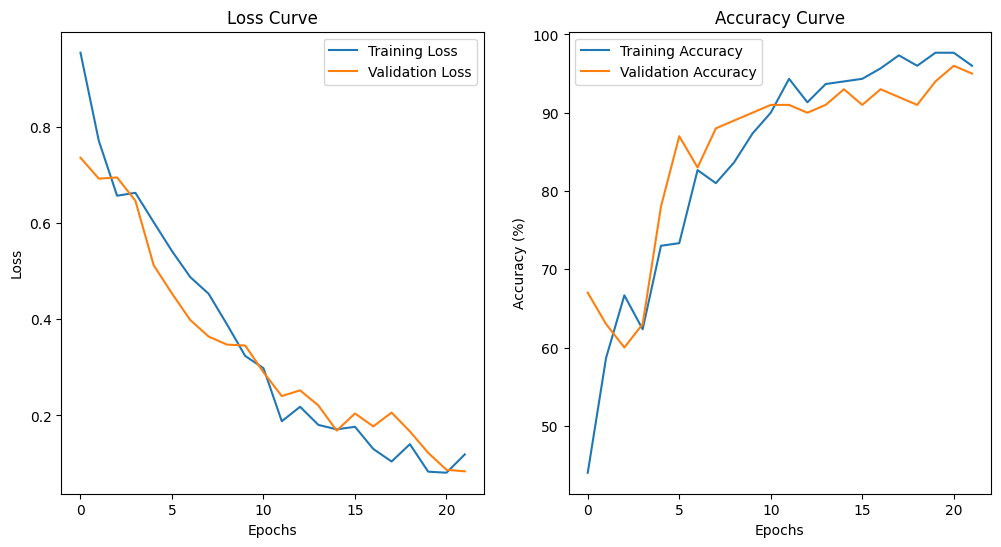

In [12]:

# Plot loss curves
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()


---
## Test the Trained Network

In [19]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
num_classes=3
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

model.eval()  # prep model for evaluation

with torch.no_grad():
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output,outputbeforefc = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        
        # compare predictions to true label and update class-wise accuracy
        correct = pred == target
        for i in range(len(target)):
            label = target[i].item()
            class_correct[label] += correct[i].item()
            class_total[label] += 1

#calcul du critère MCC (Matthew's Correlation Coefficient)
TP=class_correct[0]
TN=class_correct[1]
FP=class_total[0]-TP
FN=class_total[1]-TN
MCC=(TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
print("MCC: {:.4f}\n".format(MCC))

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of Label %d: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of Dataset %d: N/A (no testing examples)' % (i+1))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

print(output.shape)

MCC: 1.0000

Test Loss: 0.080064

Test Accuracy of Label 0: 100% (40/40)
Test Accuracy of Label 1: 100% (40/40)
Test Accuracy of Label 2: 85% (17/20)

Test Accuracy (Overall): 97% (97/100)
torch.Size([100, 3])


In [20]:
"""from sklearn.decomposition import PCA

#convert to numpy
pred_np=pred.numpy()
# Convert the tensor to numpy array
outputbeforefc_np = outputbeforefc.numpy()

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(outputbeforefc_np)
target_np=target.numpy()

# Replace the original output with the PCA result
lda_result = pca_result

# Plot the PCA result

plt.figure(figsize=(8, 6))
index1=np.where(np.logical_and(target_np==pred_np, target_np==0))
plt.scatter(lda_result[index1,0], lda_result[index1, 1], color='blue', label='Correctly predicted as sain')
index2=np.where(np.logical_and(target_np==pred_np, target_np==1))
plt.scatter(lda_result[index2,0], lda_result[index2, 1], color='red', label='Correctly predicted as sick')
index3=np.where(np.logical_and(target_np!=pred_np, target_np==0))
plt.scatter(lda_result[index3,0], lda_result[index3, 1], color='green', label='Incorrectly predicted as sick')
index4=np.where(np.logical_and(target_np!=pred_np, target_np==1))
plt.scatter(lda_result[index4,0], lda_result[index4, 1], color='orange', label='Incorrectly predicted as sain')

plt.title('PCA of the output before the fully connected layer')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()"""

"""output0=output[np.where(pred==0),:].squeeze(0)
output1=output[np.where(pred==1),:].squeeze(0)
plt.scatter(output0[:,0],output0[:,1],color="blue",label="sain")
plt.scatter(output1[:,0],output1[:,1],color="red",label="malade")
plt.legend()"""

'output0=output[np.where(pred==0),:].squeeze(0)\noutput1=output[np.where(pred==1),:].squeeze(0)\nplt.scatter(output0[:,0],output0[:,1],color="blue",label="sain")\nplt.scatter(output1[:,0],output1[:,1],color="red",label="malade")\nplt.legend()'

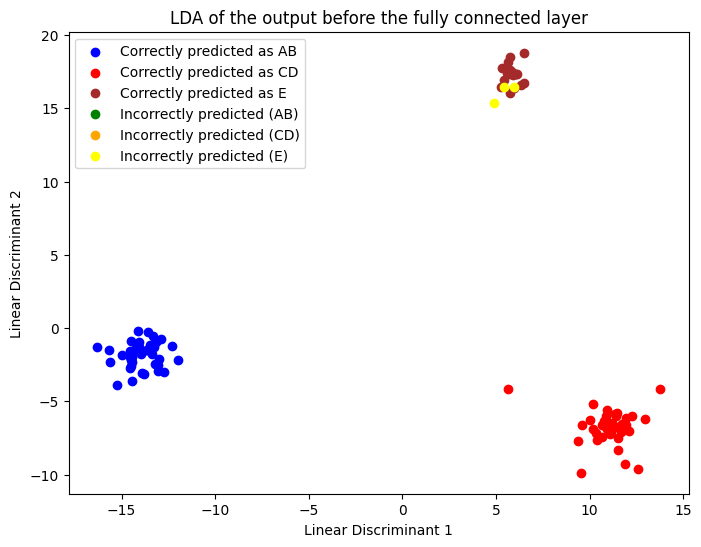

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#implement fisher analysis of the outputbeforefc signals
# Convert the tensor to numpy array
outputbeforefc_np = outputbeforefc.numpy()
target_np=target.numpy()
pred_np=pred.numpy()



# Perform LDA
lda = LDA(n_components=2)  # Reduce to 2 components for visualization
lda_result = lda.fit_transform(outputbeforefc_np, target_np)

# Plot the LDA result
plt.figure(figsize=(8, 6))
index1=np.where(np.logical_and(target_np==pred_np, target_np==0))
plt.scatter(lda_result[index1,0], lda_result[index1, 1], color='blue', label='Correctly predicted as AB')
index2=np.where(np.logical_and(target_np==pred_np, target_np==1))
plt.scatter(lda_result[index2,0], lda_result[index2, 1], color='red', label='Correctly predicted as CD')
index3=np.where(np.logical_and(target_np==pred_np, target_np==2))
plt.scatter(lda_result[index3,0], lda_result[index3, 1], color='brown', label='Correctly predicted as E')

index4=np.where(np.logical_and(target_np!=pred_np, target_np==0))
plt.scatter(lda_result[index4,0], lda_result[index4, 1], color='green', label='Incorrectly predicted (AB)')
index5=np.where(np.logical_and(target_np!=pred_np, target_np==1))
plt.scatter(lda_result[index5,0], lda_result[index5, 1], color='orange', label='Incorrectly predicted (CD)')
index6=np.where(np.logical_and(target_np!=pred_np, target_np==2))
plt.scatter(lda_result[index6,0], lda_result[index6, 1], color='yellow', label='Incorrectly predicted (E)')

plt.title('LDA of the output before the fully connected layer')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.legend()
plt.show()


'output0=output[np.where(pred==0),:].squeeze(0)\noutput1=output[np.where(pred==1),:].squeeze(0)\nplt.scatter(output0[:,0],output0[:,1],color="blue",label="sain")\nplt.scatter(output1[:,0],output1[:,1],color="red",label="malade")\nplt.legend()'

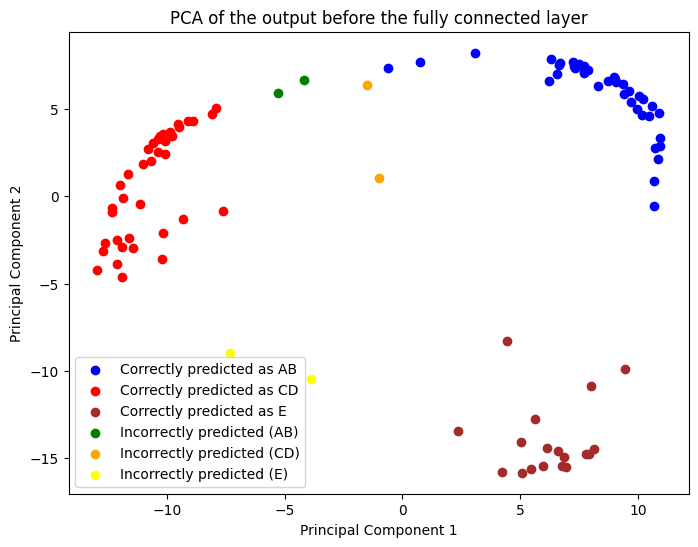

In [14]:
from sklearn.decomposition import PCA

#convert to numpy
pred_np=pred.numpy()
# Convert the tensor to numpy array
outputbeforefc_np = outputbeforefc.numpy()

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(outputbeforefc_np)
target_np=target.numpy()

# Replace the original output with the PCA result
output_np = pca_result

# Plot the PCA result

plt.figure(figsize=(8, 6))
index1=np.where(np.logical_and(target_np==pred_np, target_np==0))
plt.scatter(output_np[index1,0], output_np[index1, 1], color='blue', label='Correctly predicted as AB')
index2=np.where(np.logical_and(target_np==pred_np, target_np==1))
plt.scatter(output_np[index2,0], output_np[index2, 1], color='red', label='Correctly predicted as CD')
index3=np.where(np.logical_and(target_np==pred_np, target_np==2))
plt.scatter(output_np[index3,0], output_np[index3, 1], color='brown', label='Correctly predicted as E')

index4=np.where(np.logical_and(target_np!=pred_np, target_np==0))
plt.scatter(output_np[index4,0], output_np[index4, 1], color='green', label='Incorrectly predicted (AB)')
index5=np.where(np.logical_and(target_np!=pred_np, target_np==1))
plt.scatter(output_np[index5,0], output_np[index5, 1], color='orange', label='Incorrectly predicted (CD)')
index6=np.where(np.logical_and(target_np!=pred_np, target_np==2))
plt.scatter(output_np[index6,0], output_np[index6, 1], color='yellow', label='Incorrectly predicted (E)')

plt.title('PCA of the output before the fully connected layer')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

"""output0=output[np.where(pred==0),:].squeeze(0)
output1=output[np.where(pred==1),:].squeeze(0)
plt.scatter(output0[:,0],output0[:,1],color="blue",label="sain")
plt.scatter(output1[:,0],output1[:,1],color="red",label="malade")
plt.legend()"""